# About
This kernel applies the techniques from [fastai's deep learning for coders](http://course.fast.ai) course to the dogbreed dataset

The resulting Kaggle score is **0.22623** which roughly translates to a position in the top 30%.

# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os

from fastai.conv_learner import *

In [3]:
# make sure CUDA is available and enabled
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


In [4]:
# set competition name
comp_name = "dogbreed"

# use with custom environment
user = "ec2-user"
input_path = f"/home/{user}/data/{comp_name}/"
wd = f"/home/{user}/kaggle/{comp_name}/"

# use only with kaggle kernels
#input_path = "../input/"
#wd = "/kaggle/working/"

In [19]:
# create symlinks for easy data handling
!ln -fs {input_path}labels.csv {wd}labels.csv
!ln -fs {input_path}sample_submission.csv {wd}sample.csv
!ln -fs {input_path}train {wd}train
!ln -fs {input_path}test {wd}test

In [20]:
!ls -alh

total 7.0M
drwxrwxr-x 4 ec2-user ec2-user 4.0K Aug 24 15:56 .
drwxrwxr-x 6 ec2-user ec2-user 4.0K Aug 24 14:53 ..
drwxrwxr-x 6 ec2-user ec2-user 4.0K Aug 24 15:47 340
-rw-rw-r-- 1 ec2-user ec2-user 505K Aug 24 15:55 dogbreed_with_fastai.ipynb
drwxrwxr-x 2 ec2-user ec2-user 4.0K Aug 24 15:25 .ipynb_checkpoints
lrwxrwxrwx 1 ec2-user ec2-user   39 Aug 24 15:56 labels.csv -> /home/ec2-user/data/dogbreed/labels.csv
lrwxrwxrwx 1 ec2-user ec2-user   50 Aug 24 15:56 sample.csv -> /home/ec2-user/data/dogbreed/sample_submission.csv
-rw-rw-r-- 1 ec2-user ec2-user 6.5M Aug 24 15:23 sub_dogbreed_resnext101_64.tar.gz
lrwxrwxrwx 1 ec2-user ec2-user   34 Aug 24 15:25 test -> /home/ec2-user/data/dogbreed/test/
lrwxrwxrwx 1 ec2-user ec2-user   35 Aug 24 15:25 train -> /home/ec2-user/data/dogbreed/train/


## Helper functions to deal with Kaggle's file system limitations

In [10]:
def create_symlnk(src_dir, src_name, dst_name, dst_dir=wd, target_is_dir=False):
    """
    If symbolic link does not already exist, create it by pointing dst_dir/lnk_name to src_dir/lnk_name
    """
    if not os.path.exists(dst_dir + dst_name):
        os.symlink(src=src_dir + src_name, dst = dst_dir + dst_name, target_is_directory=target_is_dir)

In [11]:
def clean_up(wd=wd):
    """
    Delete all temporary directories and symlinks in working directory (wd)
    """
    for root, dirs, files in os.walk(wd):
        try:
            for d in dirs:
                if os.path.islink(d):
                    os.unlink(d)
                else:
                    shutil.rmtree(d)
            for f in files:
                if os.path.islink(f):
                    os.unlink(f)
                else:
                    print(f)
        except FileNotFoundError as e:
            print(e)

In [ ]:
# only use with kaggle kernels
#create_symlnk(input_path, "labels.csv", "labels.csv")
#create_symlnk(input_path, "sample_submission.csv", "sample.csv")
#create_symlnk(input_path, "train", "train", target_is_dir=True)
#create_symlnk(input_path, "test", "test", target_is_dir=True)

In [21]:
# perform sanity check
#!ls -alh

# Exploration

In [22]:
label_df = pd.read_csv(f"{wd}labels.csv")

In [23]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [24]:
label_df.shape

(10222, 2)

In [25]:
label_df.pivot_table(index="breed", aggfunc=len).sort_values("id", ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


# Preprocess data

In [26]:
# define architecture
arch = resnext101_64
sz = 224
bs = 64

In [27]:
# create indexes for validation dataset
val_idxs = get_cv_idxs(label_df.shape[0])

In [15]:
def get_data(sz=sz):
    """
    Load images via fastai's ImageClassifierData.from_csv() object defined as 'data' before
    Return images if size bigger than 300 pixels, else resize to 340 pixels
    """
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=wd, 
                                        folder="train", 
                                        csv_fname=f"{wd}labels.csv", 
                                        tfms=tfms, 
                                        val_idxs=val_idxs, 
                                        suffix=".jpg", 
                                        test_name="test")
    
    return data if sz > 300 else data.resize(340, new_path=wd)

In [17]:
data = get_data()

In [18]:
[print(len(e)) for e in [data.trn_ds, data.val_ds, data.test_ds]]

8178
2044
10357


[None, None, None]

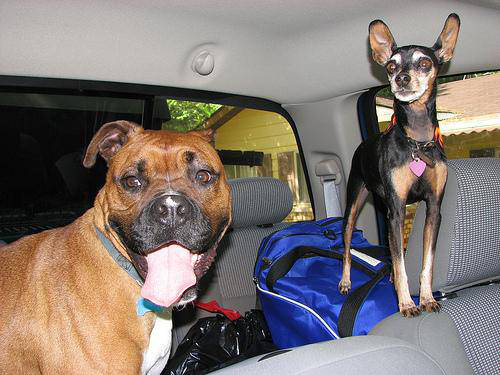

In [19]:
# look at an actual image
fn = wd + data.trn_ds.fnames[-1]
img = PIL.Image.open(fn); img

In [19]:
img.size

(500, 375)

# Model

## Baseline

In [ ]:
learn = ConvLearner.pretrained(arch, data, ps=0.5, precompute=True)

In [ ]:
lrf = learn.lr_find()

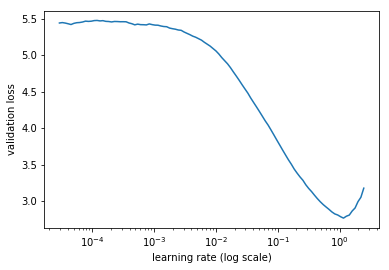

In [76]:
learn.sched.plot()

In [77]:
lr = 1e-1

In [78]:
# fit baseline model without data augmentation
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.7684     0.343147   0.893346  
    1      0.466847   0.328464   0.894325                    
    2      0.315954   0.3366     0.892857                    


[array([0.3366]), 0.892857142973786]

In [80]:
# disable precompute and fit model with data augmentation
learn.precompute=False
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.276803   0.262588   0.919276  
    1      0.269581   0.286168   0.915362                    
    2      0.229113   0.251541   0.920744                    
    3      0.252986   0.272858   0.914873                    
    4      0.231099   0.256444   0.92319                     
    5      0.193169   0.245264   0.92319                     
    6      0.164103   0.241707   0.924658                    


[array([0.24171]), 0.9246575334300734]

In [81]:
learn.save(f"{comp_name}_{arch.__name__}_{sz}_base")

In [82]:
learn.load(f"{comp_name}_{arch.__name__}_{sz}_base")

## Increase image size

In [85]:
sz = 299

In [83]:
learn.set_data(get_data(sz))

In [84]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.191909   0.247798   0.92319   
    1      0.188831   0.246921   0.929061                    
    2      0.196162   0.254115   0.921233                    


[array([0.25412]), 0.9212328763623994]

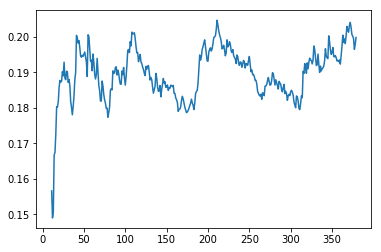

In [91]:
learn.sched.plot_loss()

In [87]:
learn.save(f"{comp_name}_{arch.__name__}_{sz}")

In [88]:
learn.load(f"{comp_name}_{arch.__name__}_{sz}")

## Prediction on validation set

In [89]:
from sklearn.metrics import log_loss

log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), log_loss(y, probs)

(0.9271037181996086, 0.2267074243237684)

## Prediction on test set

In [90]:
log_preds_test, y_test = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test), 0)

In [93]:
np.save(f"{comp_name}_probs_test", probs_test, allow_pickle=True)

In [94]:
probs_test = np.load(f"{comp_name}_probs_test.npy")

# Submission

In [95]:
df = pd.DataFrame(probs_test)
df.columns = data.classes

In [96]:
# insert clean ids - without folder prefix and .jpg suffix - of images as first column
df.insert(0, "id", [e[5:-4] for e in data.test_ds.fnames])

In [97]:
df.to_csv(f"sub_{comp_name}_{arch.__name__}.csv", index=False)

In [60]:
# only use with kaggle kernels
#clean_up()